In [77]:
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [78]:
con = sqlite3.connect("report24.sqlite")
cur = con.cursor()

In [79]:
df = pd.read_sql_query("SELECT * FROM NVTX_EVENTS", con)

In [80]:
df.head()

,start,end,eventType,rangeId,category,color,text,globalTid,endGlobalTid,textId,domainId,uint64Value,int64Value,doubleValue,uint32Value,int32Value,floatValue,jsonTextId,jsonText
0,515190044,NaN,75,NaN,NaN,NaN,evolvepy,281515980235256,None,None,1,None,None,None,None,None,None,None,None
1,515202467,NaN,33,NaN,1.0,NaN,generator_operator,281515980235256,None,None,1,None,None,None,None,None,None,None,None
2,538533219,NaN,33,NaN,2.0,NaN,evaluator,281515980235256,None,None,1,None,None,None,None,None,None,None,None
3,613678224,1.317779e+09,60,1.0,2.0,4.278227e+09,Base0,281515980235256,None,None,1,None,None,None,None,None,None,None,None
4,1318047602,2.311113e+09,60,2.0,2.0,4.278227e+09,Threads1,281515980235256,None,None,1,None,None,None,None,None,None,None,None


In [81]:
NvtxCategory = 33
NvtxStartEndRange = 60

In [82]:
mask = df["eventType"] == NvtxCategory
mask = np.bitwise_and(mask, df["text"] == "benchmark")
row = df[mask]

category_id = int(row["category"])

In [83]:
mask = df["eventType"] == NvtxStartEndRange
mask = np.bitwise_and(mask, df["category"] == category_id )
rows = df[mask]

In [84]:
evaluator_names = ["Base", "Threads", "Processes"]
base = "Base"

In [85]:
evaluator_times = {}
evaluator_stds = {}

for name in evaluator_names:
    df_eval = pd.read_sql_query("SELECT * FROM NVTX_EVENTS WHERE text LIKE '{0}%' AND category = '{1}'".format(name, category_id), con)
    df_eval["population_size"] = df_eval.apply(lambda x: int(x["text"].split("_")[-1]), axis=1)
    df_eval.sort_values("population_size", inplace=True)

    sizes = np.unique(np.array(df_eval["population_size"]))
    times = []
    stds = []
    for size in sizes:
        mask = df_eval["population_size"] == size
        end = df_eval[mask]["end"].to_numpy()
        start = df_eval[mask]["start"].to_numpy()

        size_times = end-start
        times.append(np.mean(size_times))
        stds.append(np.std(size_times))

    evaluator_times[name] = np.array(times)
    evaluator_stds[name] = np.array(stds)

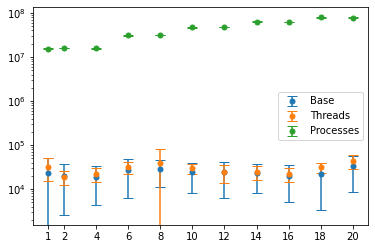

In [98]:
for name in evaluator_names:
    plt.errorbar(sizes, evaluator_times[name], evaluator_stds[name], fmt="o", capsize=5.0, markersize=5.0, label=name)

plt.xticks(sizes)
plt.legend()
plt.yscale("log")

In [87]:
def compute_u_speedup(base, u_base, accelerated, u_accelerated):
    u_speedup = np.power(u_accelerated, 2)*np.power(base, 2)/np.power(accelerated, 4)
    u_speedup += np.power(u_base, 2)/np.power(accelerated, 2)
    u_speedup = np.sqrt(u_speedup)

    return u_speedup

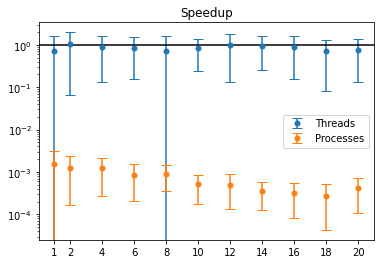

In [96]:
for name in evaluator_names:
    if name != base:
        speedup = evaluator_times[base]/evaluator_times[name]
        u_speedup = compute_u_speedup(evaluator_times[base], evaluator_stds[base], evaluator_times[name], evaluator_stds[name])
        plt.errorbar(sizes, speedup, u_speedup, fmt="o", capsize=5.0, markersize=5.0, label=name)

plt.axhline(1, color="black")

plt.title("Speedup")
plt.xticks(sizes)
plt.legend()
plt.yscale("log")
plt.show()

In [89]:
raise ValueError

ValueError: 

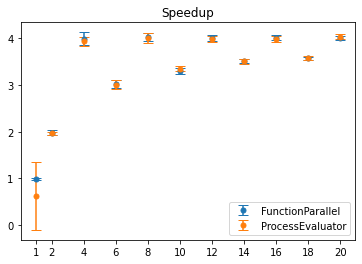

In [ ]:
base = "FunctionEvaluator"

for name in evaluator_names:
    if name != base:
        speedup = evaluator_times[base]/evaluator_times[name]
        u_speedup = compute_u_speedup(evaluator_times[base], evaluator_stds[base], evaluator_times[name], evaluator_stds[name])
        plt.errorbar(sizes, speedup, u_speedup, fmt="o", capsize=5.0, markersize=5.0, label=name)

plt.title("Speedup")
plt.xticks(sizes)
plt.legend()
plt.show()